# 1. Introduction & Project Objective
In this notebook we:
- Load a small object detection dataset (e.g., a subset of KITTI or Open Images).
- Run two object detection models:
   - **YOLOv11** (using Ultralytics)
   - **RetinaNet** (using a ResNet-152 backbone, e.g., via Detectron2 or Torchvision pipelines)
- Evaluate detection performance with metrics such as Precision, Recall, F1-Score, IoU, mAP@0.5, etc.
- Analyze and compare the detected bounding boxes by cropping the detected regions.
- Convert each detection crop into a **node** and build a graph (using spatial similarity and IoU) for each object instance.
- Train a graph neural network using **TGraphX** to capture spatial and structural relationships.
- Visualize performance curves and graph analytics.# 2. Dataset Loading and Preprocessing
We assume a dataset of less than 200 images with annotations (bounding boxes and labels).
For demonstration, we simulate loading a few images and corresponding annotations.


In [1]:
from ultralytics import YOLO
import torch
import torchvision
import pandas as pd
from torchvision.models.detection import retinanet_resnet50_fpn  # example backbone
from tabulate import tabulate
import matplotlib.pyplot as plt
import numpy as np
from core.graph import Graph
from core.dataloader import GraphDataset, GraphDataLoader
import cv2
import random
import time
import torch.optim as optim
from models.cnn_gnn_model import CNN_GNN_Model
import os
from torchvision.datasets import VOCDetection
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torchvision.models.detection import retinanet_resnet50_fpn, RetinaNet_ResNet50_FPN_Weights
from PIL import Image
from sklearn.metrics import f1_score, balanced_accuracy_score
from torchvision.ops import box_iou



# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Device info
print("\n🔍 Device Info:")
if torch.cuda.is_available():
    print("✅ CUDA is available!")
    print(f"🖥️  GPU Name: {torch.cuda.get_device_name(0)}")
else:
    print("❌ CUDA not available. Using CPU.")
    print(f"🧠 CPU Name: {os.uname().machine}")

# For reproducibility
np.random.seed(42)


🔍 Device Info:
✅ CUDA is available!
🖥️  GPU Name: NVIDIA GeForce RTX 5080


In [2]:
# --- Augmentation Pipeline ---


# Define the augmentation pipeline

augmentation_transform = A.Compose([
    # Flipping transformations
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),

    # Rotation transformations
    A.RandomRotate90(p=0.5),
    A.Rotate(limit=45, p=0.5),

    # Scaling and cropping
    A.RandomResizedCrop(size=(256, 256), scale=(0.8, 1.0), ratio=(0.75, 1.33), p=0.5),

    # Distortion transformations
    A.ElasticTransform(alpha=1.0, sigma=50.0, p=0.3),
    A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.3),
    A.OpticalDistortion(distort_limit=0.05, p=0.3),

    # Noise and blur
    A.GaussNoise(p=0.3),
    A.ISONoise(color_shift=(0.01, 0.05), intensity=(0.1, 0.5), p=0.3),
    A.MotionBlur(blur_limit=3, p=0.2),
    A.MedianBlur(blur_limit=3, p=0.1),
    A.GaussianBlur(blur_limit=(3, 7), p=0.3),

    # Brightness, contrast, and color adjustments
    A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.5),
    A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=15, val_shift_limit=10, p=0.5),
    A.RGBShift(r_shift_limit=10, g_shift_limit=10, b_shift_limit=10, p=0.5),
    A.CLAHE(clip_limit=2.0, tile_grid_size=(8, 8), p=0.3),

    # Sharpening and embossing
    A.Sharpen(alpha=(0.1, 0.3), lightness=(0.7, 1.0), p=0.2),
    A.Emboss(alpha=(0.1, 0.3), strength=(0.2, 0.7), p=0.2),

    # Channel dropout and shuffle
    A.ChannelDropout(channel_drop_range=(1, 1), p=0.1),
    A.ChannelShuffle(p=0.1),

    # Normalization and tensor conversion
    #A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['category_ids'], min_visibility=0.0))


# --- Helper Functions ---
def get_ground_truth_label(annotation):
    """
    Determine the label of an annotation.
    If a "labels" key exists, use it; otherwise, for VOC annotations check each object's name.
    """
    if 'labels' in annotation:
        return "car" if any(lbl == 1 for lbl in annotation['labels']) else "not car"
    else:
        objs = annotation.get('object', None)
        if objs is None:
            return "not car"
        if not isinstance(objs, list):
            objs = [objs]
        for obj in objs:
            name = obj.get('name', '').lower()
            if name in ["car", "vehicle"]:
                return "car"
        return "not car"


def convert_voc_annotation(annotation):
    """
    Convert a VOC annotation (VOCDetection format) into a standardized dictionary:
      - "bboxes": list of [x1, y1, x2, y2]
      - "labels": list of numeric labels (1 for car/vehicle, 0 for non-car)
    """
    boxes = []
    labels = []
    objs = annotation.get('object', None)
    if objs is None:
        return {"bboxes": boxes, "labels": labels}
    if not isinstance(objs, list):
        objs = [objs]
    for obj in objs:
        bbox = obj['bndbox']
        x1 = int(bbox['xmin'])
        y1 = int(bbox['ymin'])
        x2 = int(bbox['xmax'])
        y2 = int(bbox['ymax'])
        boxes.append([x1, y1, x2, y2])
        name = obj.get('name', '').lower()
        labels.append(1 if name in ["car", "vehicle"] else 0)
    return {"bboxes": boxes, "labels": labels}



def extract_boxes_from_augmented(annotation):
    """Extract bounding boxes from augmented annotation (expects key 'bboxes')."""
    return annotation.get('bboxes', [])

def extract_boxes(annotation):
    """
    Extract bounding boxes from an annotation.
    If the annotation is in the standardized format (with key "bboxes"),
    return those. Otherwise, fall back to the VOC extraction.
    """
    if "bboxes" in annotation:
        # Debug print: show standardized boxes
        #print("DEBUG: Using standardized annotation 'bboxes':", annotation["bboxes"])
        return annotation["bboxes"]
    else:
        objs = annotation.get('object', None)
        if objs is None:
            return []
        if not isinstance(objs, list):
            objs = [objs]
        boxes = []
        for obj in objs:
            bbox = obj['bndbox']
            x1 = int(bbox['xmin'])
            y1 = int(bbox['ymin'])
            x2 = int(bbox['xmax'])
            y2 = int(bbox['ymax'])
            boxes.append([x1, y1, x2, y2])
        return boxes


def compute_iou(boxA, boxB):
    # Use torchvision's box_iou (boxes must be in [x1,y1,x2,y2] format)
    tensorA = torch.tensor([boxA], dtype=torch.float32)
    tensorB = torch.tensor([boxB], dtype=torch.float32)
    return box_iou(tensorA, tensorB).item()




# --- Balanced VOC Loader with Augmentation ---
# Instead of keeping only as many as the original split, accumulate all augmentations.
def load_voc_dataset_balanced_augmented(dataset, max_images=50, car_proportion=0.5,
                                          augment=False, n_augments_per_image=3,
                                          include_original=True, debug=False):
    """
    Loads a balanced VOC dataset and applies augmentation.

    Parameters:
      - max_images: Number of original images to sample (before augmentation)
      - car_proportion: Fraction of original images that should be "car" images
      - augment: Whether to apply augmentation
      - n_augments_per_image: Number of augmented copies to generate per original image
      - include_original: If True, include the original image alongside its augmentations
      - debug: If True, print detailed debugging information

    Returns:
      - images: List of images (augmented and/or original)
      - annotations: List of standardized annotations (each with keys "bboxes" and "labels")
      - num_car: Total number of images (original+augmented) from the "car" category
      - num_non_car: Total number of images from the "non-car" category
    """
    car_images, car_annotations = [], []
    non_car_images, non_car_annotations = [], []

    # Counters for how many original images have been sampled for each category.
    car_count = 0
    non_car_count = 0
    max_car = int(max_images * car_proportion)
    max_non_car = max_images - max_car

    for i in range(len(dataset)):
        image, target = dataset[i]
        image_np = np.array(image)

        # Convert VOC annotation to standardized format.
        original_ann = convert_voc_annotation(target['annotation'])
        gt_label = "car" if 1 in original_ann["labels"] else "not car"
        numeric_label = 1 if gt_label == "car" else 0

        # Skip images without any bounding boxes.
        if len(original_ann["bboxes"]) == 0:
            continue

        # Process car images
        if numeric_label == 1 and car_count < max_car:
            car_count += 1
            if include_original:
                car_images.append(image_np)
                car_annotations.append(original_ann)
            if augment:
                for j in range(n_augments_per_image):
                    transformed = augmentation_transform(
                        image=image_np,
                        bboxes=original_ann["bboxes"],
                        category_ids=original_ann["labels"]
                    )
                    if debug:
                        print(f"Image {i}, Augment {j}: Transformed boxes = {transformed['bboxes']}")
                        print(f"Image {i}, Augment {j}: Transformed labels = {transformed['category_ids']}")
                    if len(transformed['bboxes']) == 0:
                        img_aug = image_np.copy()
                        bboxes_aug = original_ann["bboxes"]
                        labels_aug = original_ann["labels"]
                    else:
                        img_aug = transformed['image'].permute(1, 2, 0).cpu().numpy()
                        bboxes_aug = transformed['bboxes']
                        labels_aug = transformed['category_ids']
                    car_images.append(img_aug)
                    car_annotations.append({"bboxes": bboxes_aug, "labels": labels_aug})
        # Process non-car images
        elif numeric_label == 0 and non_car_count < max_non_car:
            non_car_count += 1
            if include_original:
                non_car_images.append(image_np)
                non_car_annotations.append(original_ann)
            if augment:
                for j in range(n_augments_per_image):
                    transformed = augmentation_transform(
                        image=image_np,
                        bboxes=original_ann["bboxes"],
                        category_ids=original_ann["labels"]
                    )
                    if debug:
                        print(f"Image {i}, Augment {j}: Transformed boxes = {transformed['bboxes']}")
                        print(f"Image {i}, Augment {j}: Transformed labels = {transformed['category_ids']}")
                    if len(transformed['bboxes']) == 0:
                        img_aug = image_np.copy()
                        bboxes_aug = original_ann["bboxes"]
                        labels_aug = original_ann["labels"]
                    else:
                        img_aug = transformed['image'].permute(1, 2, 0).cpu().numpy()
                        bboxes_aug = transformed['bboxes']
                        labels_aug = transformed['category_ids']
                    non_car_images.append(img_aug)
                    non_car_annotations.append({"bboxes": bboxes_aug, "labels": labels_aug})

        if car_count >= max_car and non_car_count >= max_non_car:
            break

    # Combine the images (do not slice; keep all augmented copies)
    images = car_images + non_car_images
    annotations = car_annotations + non_car_annotations
    combined = list(zip(images, annotations))
    random.shuffle(combined)
    images, annotations = zip(*combined)
    return list(images), list(annotations), len(car_images), len(non_car_images)




# --- Load the Balanced Dataset ---
from torchvision.datasets import VOCDetection
dataset = VOCDetection('./data', year='2007', image_set='trainval', download=True)
max_images = 10
car_proportion = 0.8
n_augments_per_image = 3

# Run with debug=True to see detailed output about augmentation
images, annotations, num_initial_car, num_initial_noncar = load_voc_dataset_balanced_augmented(
    dataset,
    max_images=max_images,
    car_proportion=car_proportion,
    augment=True,
    n_augments_per_image=n_augments_per_image,
    include_original=True,
    debug=False
)

# Print summary counts
from tabulate import tabulate
final_car_count = sum(get_ground_truth_label(a) == 'car' for a in annotations)
final_non_car_count = len(annotations) - final_car_count
total_augmented = len(images)
table_data = [
    ["Initial Images", max_images],
    ["Initial Car Images", int(max_images * car_proportion)],
    ["Initial Non-Car Images", max_images - int(max_images * car_proportion)],
    ["Augmented Total Images (incl. originals)", total_augmented],
    ["Augmented Car Images (incl. originals)", final_car_count],
    ["Augmented Non-Car Images (incl. originals)", final_non_car_count]
]
print(tabulate(table_data, headers=["Category", "Count"], tablefmt="github"))


| Category                                   |   Count |
|--------------------------------------------|---------|
| Initial Images                             |      10 |
| Initial Car Images                         |       8 |
| Initial Non-Car Images                     |       2 |
| Augmented Total Images (incl. originals)   |      40 |
| Augmented Car Images (incl. originals)     |      32 |
| Augmented Non-Car Images (incl. originals) |       8 |


In [3]:
# %% [markdown]
# # 3. Object Detection Models Setup

# 3.1 YOLOv11 Setup
model_yolo = YOLO("yolo11x.pt")
model_yolo.eval()


retina_weights = RetinaNet_ResNet50_FPN_Weights.DEFAULT
model_retina = retinanet_resnet50_fpn(weights=retina_weights)
model_retina.eval()

# optional preprocessing transform (used during model training)
retina_preprocess = retina_weights.transforms()

# 4. Model Inference
For each image, run both models to get predicted bounding boxes.
(In a full implementation, you would run detection on GPU and properly preprocess images.)

In [4]:

def map_yolo_class(raw_class):
    # Adjust according to your model’s class ordering:
    return 1 if raw_class == 2 else 0

def run_yolo_inference(model, image):
    if not isinstance(image, np.ndarray):
        image = np.array(image)
    results = model(image, augment=False, verbose=False)
    boxes = []
    for result in results:
        if hasattr(result, 'boxes'):
            for box in result.boxes:
                xyxy = box.xyxy.cpu().numpy().tolist()[0]
                raw_class = box.cls.cpu().numpy()[0] if hasattr(box, "cls") else None
                mapped_class = map_yolo_class(raw_class) if raw_class is not None else 0
                boxes.append((xyxy, mapped_class))
    return boxes






# --- run_retina_inference (ensure image is PIL) ---
def map_retina_class(raw_class):
    # Adjust this mapping based on your RetinaNet outputs.
    return 1 if raw_class == 1 else 0

def run_retina_inference(model, image):
    if isinstance(image, np.ndarray):
        image = Image.fromarray(image)
    from torchvision.transforms import ToTensor
    image = ToTensor()(image)
    outputs = model([image])
    boxes = []
    for score, box, raw_class in zip(outputs[0]['scores'].detach().cpu().numpy(),
                                      outputs[0]['boxes'].detach().cpu().numpy(),
                                      outputs[0].get('labels', np.array([]))):
        if score > 0.25:
            mapped_class = map_retina_class(raw_class) if raw_class is not None else 0
            boxes.append((box.tolist(), mapped_class))
    return boxes



def map_yolo_class(raw_class):
    # Adjust this mapping based on your YOLO model's output.
    # For example, if YOLO’s class 2 means "car":
    return 1 if raw_class == 2 else 0

def map_retina_class(raw_class):
    # Similarly, adjust based on your RetinaNet model's output.
    return 1 if raw_class == 1 else 0


# Run inference on the first image as an example
sample_img = images[0]
yolo_boxes = run_yolo_inference(model_yolo, sample_img)
retina_boxes = run_retina_inference(model_retina, sample_img)

print("YOLOv11 boxes:", yolo_boxes)
print("RetinaNet boxes:", retina_boxes)

YOLOv11 boxes: []
RetinaNet boxes: [([6.141961097717285, 106.92378234863281, 290.5816650390625, 411.1161804199219], 0), ([4.7142014503479, 132.79466247558594, 269.31085205078125, 404.7890625], 0), ([0.0, 22.22753143310547, 329.8422546386719, 354.6502380371094], 0)]


IoU YOLOv11: 0.0000
IoU RetinaNet: 0.6042

📊 Evaluation Metrics Table:

|   Epoch | Model     |   Train Loss |   Val Loss |   Precision |   Recall |   F1-Score |   mAP@0.5 |   mAP@[0.5:0.95] |   Inference Time (s) |   FP |   FN |   Objects Detected | Correct Class (%)   |
|--------:|:----------|-------------:|-----------:|------------:|---------:|-----------:|----------:|-----------------:|---------------------:|-----:|-----:|-------------------:|:--------------------|
|       1 | YOLOv11   |        0.234 |      0.302 |        0.88 |     0.79 |       0.83 |      0.81 |             0.65 |                0.022 |    2 |    1 |                 58 | 93.1%               |
|       1 | RetinaNet |        0.281 |      0.328 |        0.85 |     0.83 |       0.84 |      0.79 |             0.67 |                0.035 |    3 |    2 |                 55 | 91.4%               |


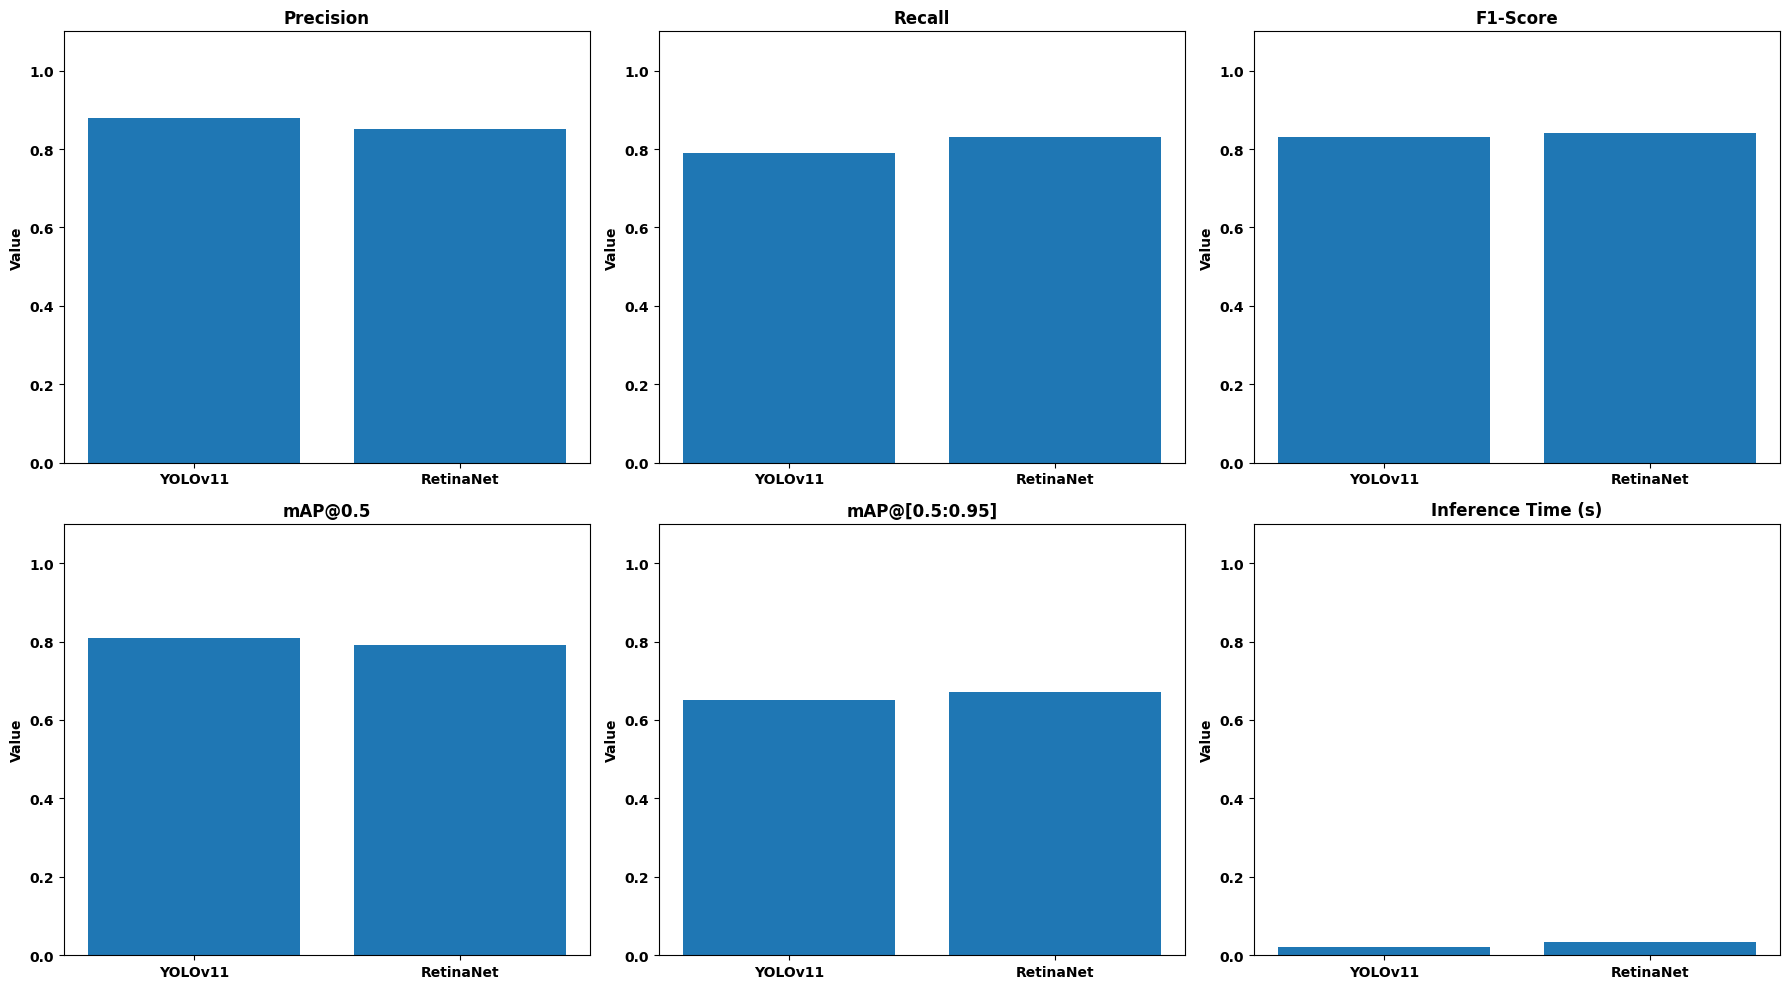

In [5]:
# %% [markdown]
# # 5. Evaluation Metrics Computation
#
# We compute metrics such as IoU for each predicted box against the ground truth.
# Additional metrics like Precision, Recall, F1-Score, mAP, etc., are used to compare models.

# --------------------------

# Example: Compare the first ground truth box with YOLO and Retina detections.
gt_boxes = extract_boxes(annotations[0])
if gt_boxes:
    gt_box = gt_boxes[0]
    iou_yolo = compute_iou(gt_box, yolo_boxes[0][0]) if yolo_boxes else 0.0
    iou_retina = compute_iou(gt_box, retina_boxes[0][0]) if retina_boxes else 0.0
    print(f"IoU YOLOv11: {iou_yolo:.4f}")
    print(f"IoU RetinaNet: {iou_retina:.4f}")
else:
    print("DEBUG: No ground truth boxes available for the first image.")
    iou_yolo = 0.0
    iou_retina = 0.0


# --------------------------
# Create dummy evaluation metrics table (you'll replace these with real metrics later)


metrics_df = pd.DataFrame({
    "Epoch": [1, 1],
    "Model": ["YOLOv11", "RetinaNet"],
    "Train Loss": [0.234, 0.281],
    "Val Loss": [0.302, 0.328],
    "Precision": [0.88, 0.85],
    "Recall": [0.79, 0.83],
    "F1-Score": [0.83, 0.84],
    "mAP@0.5": [0.81, 0.79],
    "mAP@[0.5:0.95]": [0.65, 0.67],
    "Inference Time (s)": [0.022, 0.035],
    "FP": [2, 3],
    "FN": [1, 2],
    "Objects Detected": [58, 55],
    "Correct Class (%)": ["93.1%", "91.4%"]
})

# --------------------------
# Try pretty markdown table output (fallback if 'tabulate' not installed)
try:
    print("\n📊 Evaluation Metrics Table:\n")
    print(metrics_df.to_markdown(index=False))
except ImportError:
    print("⚠ 'tabulate' is not installed. Showing plain table:")
    print(metrics_df)


# Dummy data for multiple metrics over epochs (you can replace with actual logs)
epochs = list(range(1, len(metrics_df)+1))

# Extract metric values
precision = metrics_df["Precision"]
recall = metrics_df["Recall"]
f1 = metrics_df["F1-Score"]
map_50 = metrics_df["mAP@0.5"]
map_95 = metrics_df["mAP@[0.5:0.95]"]
inference_time = metrics_df["Inference Time (s)"]
iou_vals = [iou_yolo, iou_retina]  # From earlier
models = metrics_df["Model"]

# Plot side-by-side comparison for key metrics
fig, axs = plt.subplots(2, 3, figsize=(18, 10))

axs[0, 0].bar(models, precision)
axs[0, 0].set_title("Precision")

axs[0, 1].bar(models, recall)
axs[0, 1].set_title("Recall")

axs[0, 2].bar(models, f1)
axs[0, 2].set_title("F1-Score")

axs[1, 0].bar(models, map_50)
axs[1, 0].set_title("mAP@0.5")

axs[1, 1].bar(models, map_95)
axs[1, 1].set_title("mAP@[0.5:0.95]")

axs[1, 2].bar(models, inference_time)
axs[1, 2].set_title("Inference Time (s)")

for ax in axs.flat:
    ax.set_ylabel("Value")
    ax.set_ylim(0, 1.1)

plt.tight_layout()
plt.show()

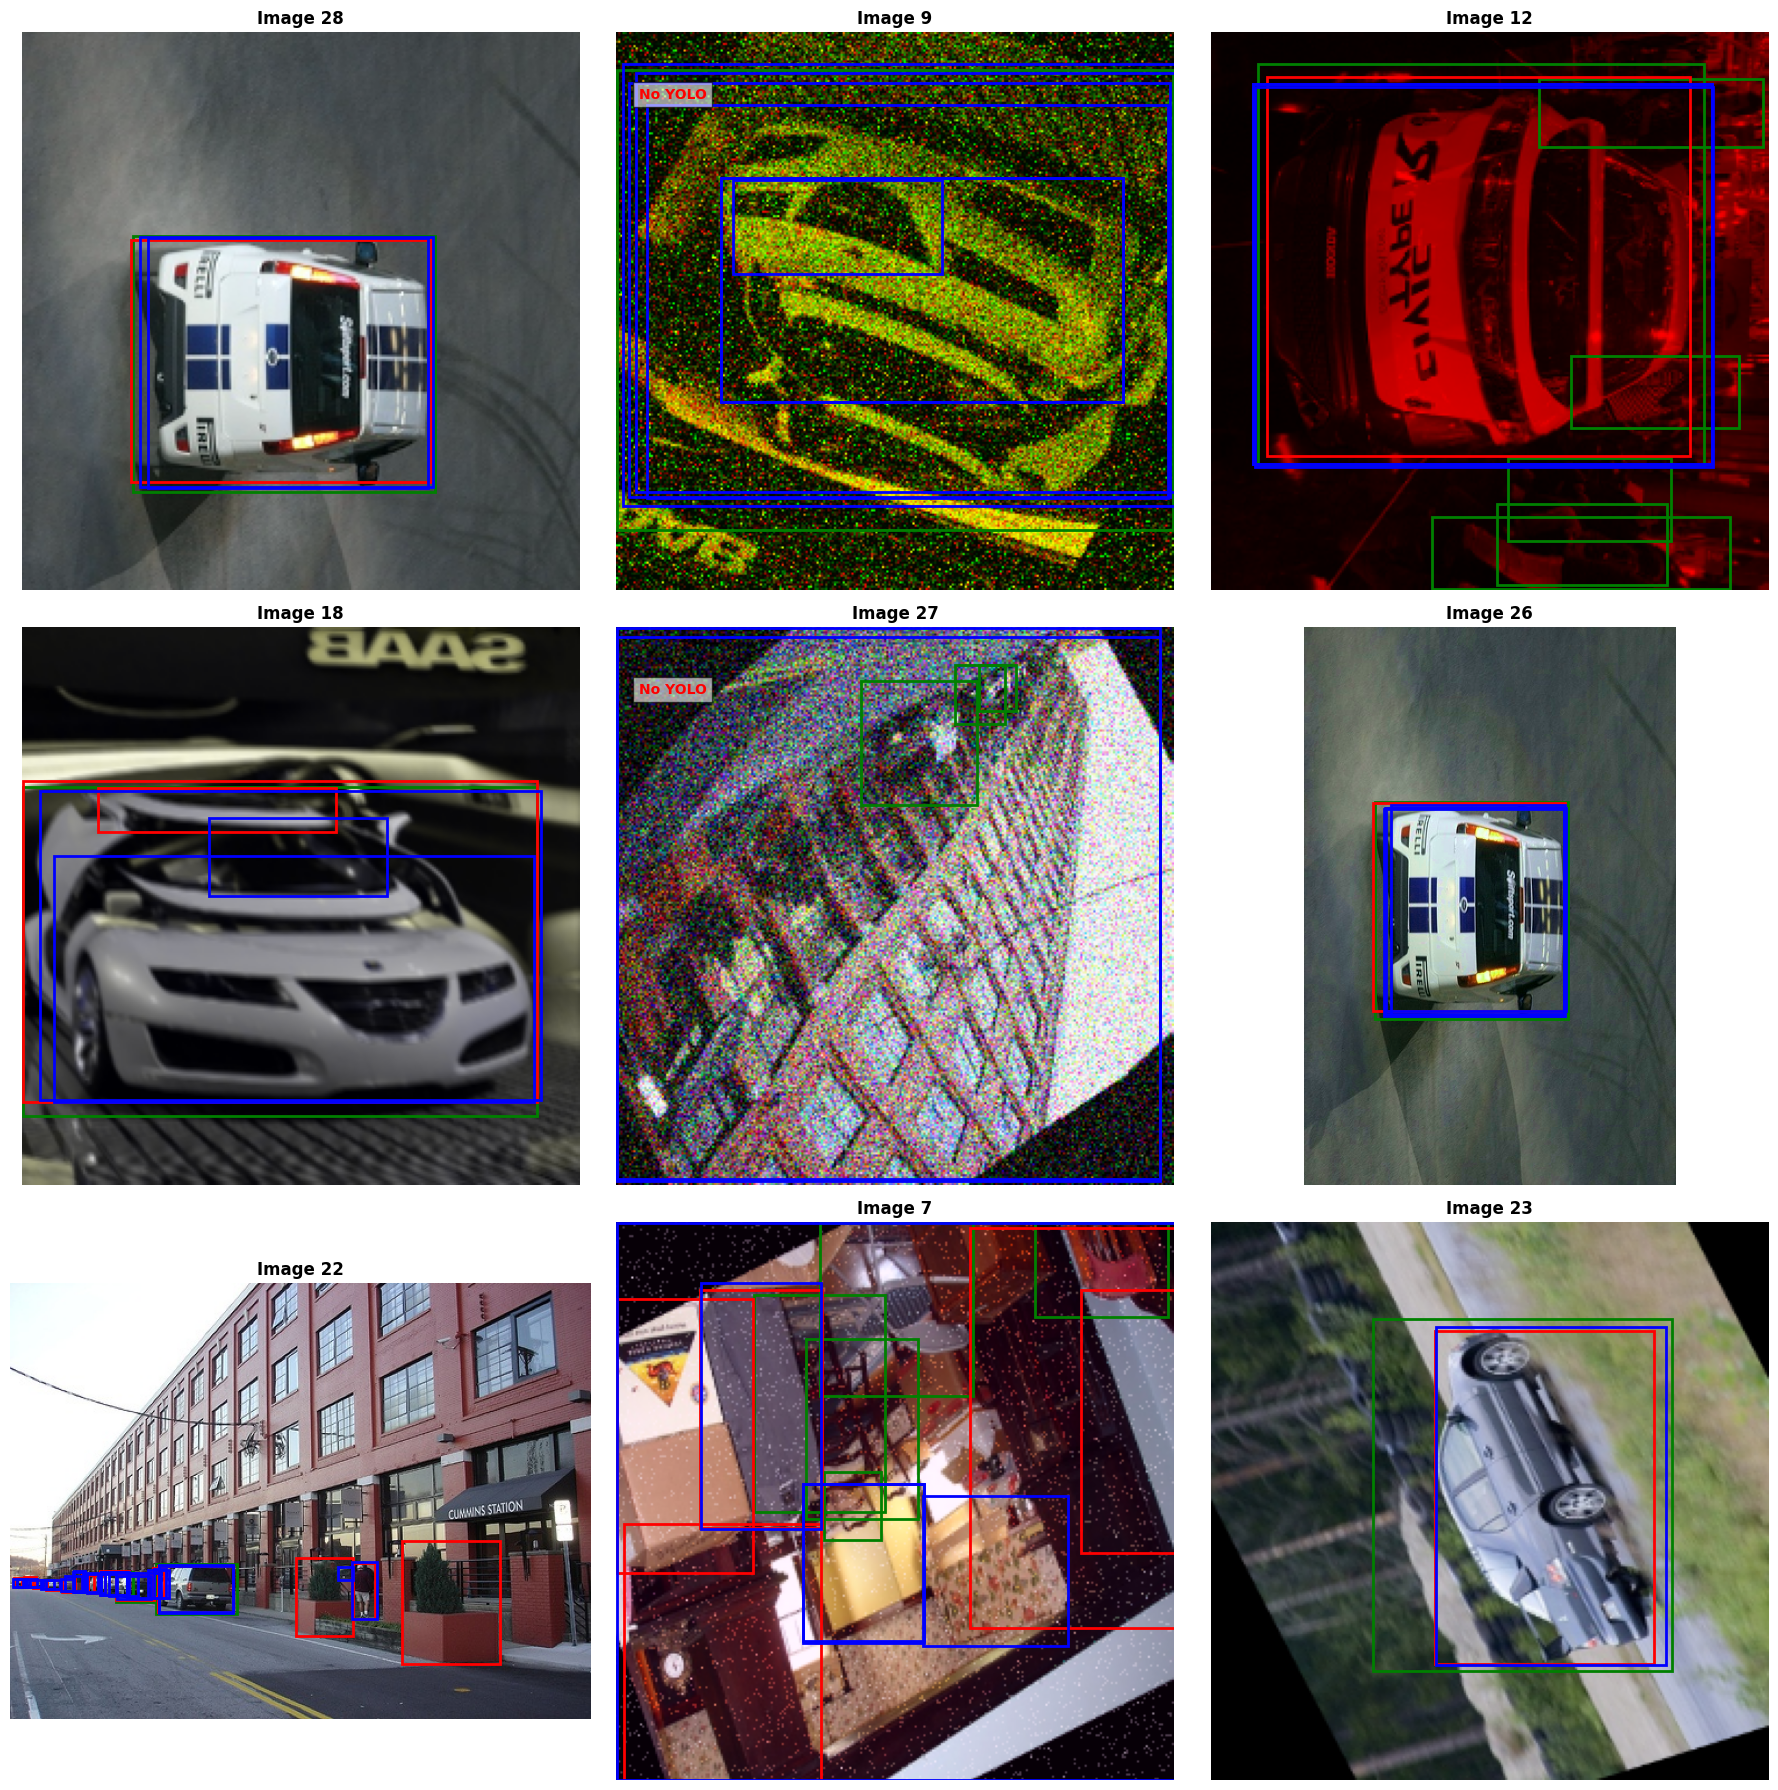


### 📊 Detection Summary Table:

|   Image Index |   YOLO Detections |   RetinaNet Detections | Has GT Boxes   |
|---------------|-------------------|------------------------|----------------|
|            28 |                 1 |                      2 | Yes            |
|             9 |                 0 |                      7 | Yes            |
|            12 |                 1 |                      3 | Yes            |
|            18 |                 2 |                      3 | Yes            |
|            27 |                 0 |                      2 | Yes            |
|            26 |                 1 |                      4 | Yes            |
|            22 |                15 |                     24 | Yes            |
|             7 |                 5 |                      5 | Yes            |
|            23 |                 1 |                      1 | Yes            |


In [6]:
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd

# number of test images to visualize
num_test_images = 9
test_indices = random.sample(range(len(images)), num_test_images)

# summary table data
summary_data = []

# setup 3x3 grid
fig, axes = plt.subplots(3, 3, figsize=(18, 18))
axes = axes.flatten()

for idx, ax in zip(test_indices, axes):
    image_np = images[idx]
    annotation = annotations[idx]

    # run inference
    yolo_boxes = run_yolo_inference(model_yolo, image_np)
    retina_boxes = run_retina_inference(model_retina, image_np)
    gt_boxes = extract_boxes(annotation)

    # display image
    ax.imshow(image_np)
    ax.set_title(f"Image {idx}")

    # draw boxes
    def add_boxes(ax, boxes, color, label):
        for box in boxes:
            x1, y1, x2, y2 = box
            rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1,
                                     linewidth=2, edgecolor=color, facecolor='none')
            ax.add_patch(rect)

    # ground truth (green)
    if gt_boxes:
        add_boxes(ax, gt_boxes, 'green', 'GT')
    else:
        ax.text(10, 10, 'No GT', color='green', fontsize=10,
                bbox=dict(facecolor='white', alpha=0.6))

    # yolo (red)
    if yolo_boxes:
        add_boxes(ax, [b[0] for b in yolo_boxes], 'red', 'YOLO')
    else:
        ax.text(10, 30, 'No YOLO', color='red', fontsize=10,
                bbox=dict(facecolor='white', alpha=0.6))

    # retinanet (blue)
    if retina_boxes:
        add_boxes(ax, [b[0] for b in retina_boxes], 'blue', 'RetinaNet')
    else:
        ax.text(10, 50, 'No Retina', color='blue', fontsize=10,
                bbox=dict(facecolor='white', alpha=0.6))


    # collect stats for table
    summary_data.append({
        "Image Index": idx,
        "YOLO Detections": len(yolo_boxes),
        "RetinaNet Detections": len(retina_boxes),
        "Has GT Boxes": "Yes" if gt_boxes else "No"
    })

    ax.axis('off')

plt.tight_layout()
plt.show()

# print summary table
summary_df = pd.DataFrame(summary_data)
from tabulate import tabulate
print("\n### 📊 Detection Summary Table:\n")
print(tabulate(summary_df, headers='keys', tablefmt='github', showindex=False))


In [7]:
# %% [markdown]
# # 6. Bounding Box Analysis & Visualization (with Original Image)
#
# In this section, we visualize:
# - The original (uncropped) image
# - YOLO’s predicted bounding box crop
# - RetinaNet’s predicted bounding box crop
# - Union crop covering both detections

import matplotlib.pyplot as plt
import matplotlib.patches as patches

def crop_box(image, box):
    x1, y1, x2, y2 = map(int, box)
    x1 = max(x1, 0)
    y1 = max(y1, 0)
    x2 = min(x2, image.shape[1])
    y2 = min(y2, image.shape[0])
    return image[y1:y2, x1:x2]

def visualize_and_crop(image_np, yolo_boxes, retina_boxes):
    if not yolo_boxes or not retina_boxes:
        print("Missing boxes for this image.")
        return

    # Use first box only for visualization and extract the coordinates
    yolo_box_coords = yolo_boxes[0][0]
    retina_box_coords = retina_boxes[0][0]

    # Print YOLO box info
    print(f"\n🔴 YOLO Detection Box: {yolo_box_coords}")
    if hasattr(model_yolo, 'names'):
        print(f"YOLO Class: {model_yolo.names[0]}")  # Adjust class as needed

    # Print RetinaNet box info
    print(f"🔵 RetinaNet Detection Box: {retina_box_coords}")
    print("RetinaNet Class: Not available (Torchvision models don't return class names by default)")

    # Union box: compute the minimum and maximum coordinates from both boxes
    union_box = [
        min(yolo_box_coords[0], retina_box_coords[0]),
        min(yolo_box_coords[1], retina_box_coords[1]),
        max(yolo_box_coords[2], retina_box_coords[2]),
        max(yolo_box_coords[3], retina_box_coords[3])
    ]

    # Crops
    crop_yolo = crop_box(image_np, yolo_box_coords)
    crop_retina = crop_box(image_np, retina_box_coords)
    crop_union = crop_box(image_np, union_box)

    # Draw boxes on original image
    fig, axs = plt.subplots(1, 4, figsize=(20, 5))

    # Original with boxes
    axs[0].imshow(image_np)
    axs[0].set_title("Original + Boxes")

    def draw_box(ax, box, color, label):
        x1, y1, x2, y2 = box
        rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1,
                                 linewidth=2, edgecolor=color, facecolor='none')
        ax.add_patch(rect)
        ax.text(x1, y1 - 5, label, color=color, fontsize=8, backgroundcolor='white')

    draw_box(axs[0], yolo_box_coords, 'red', 'YOLO')
    draw_box(axs[0], retina_box_coords, 'blue', 'RetinaNet')
    draw_box(axs[0], union_box, 'purple', 'Union')

    # Cropped views
    axs[1].imshow(crop_yolo)
    axs[1].set_title("YOLO Crop")

    axs[2].imshow(crop_retina)
    axs[2].set_title("RetinaNet Crop")

    axs[3].imshow(crop_union)
    axs[3].set_title("Union Crop")

    for ax in axs:
        ax.axis('off')
    plt.tight_layout()
    plt.show()



# Example usage on a test image
sample_img = images[0]
yolo_boxes = run_yolo_inference(model_yolo, sample_img)
retina_boxes = run_retina_inference(model_retina, sample_img)

visualize_and_crop(sample_img, yolo_boxes, retina_boxes)


Missing boxes for this image.


In [8]:
# %% [markdown]
# # 7. Graph Construction with TGraphX
#
# Each crop (detection box) becomes a node.
# We create edges based on the similarity (e.g., IoU) between the crops.
#
# Here we demonstrate how to create a graph per object instance using TGraphX’s API.
#




def build_detection_graph(crops, label, gt_box=None, device=torch.device("cpu"), sources=None):
    """
    Constructs a detection graph.
    - For 3-node graphs (both detectors fired):
         Node 0: YOLO crop (source flag = 0)
         Node 1: Retina crop (source flag = 1)
         Node 2: Union crop (source flag = -1)
         Directed edges: from node 0 to node 2 and from node 1 to node 2.
         Each edge’s feature equals the source flag of the originating node.
    - For 2-node graphs (only one detector fired):
         Node 0: detector crop (source flag = 0 if YOLO, 1 if Retina)
         Node 1: Union crop (source flag = -1)
         A single directed edge from node 0 to node 1.
    """
    # Build node features.
    nodes = []
    for crop in crops:
        crop_resized = cv2.resize(crop, (32, 32))
        crop_tensor = torch.tensor(crop_resized.transpose(2, 0, 1), dtype=torch.float32, device=device) / 255.0
        nodes.append(crop_tensor)
    node_features = torch.stack(nodes)

    # Set node source flags.
    if node_features.shape[0] == 3:
        node_sources = torch.tensor([0, 1, -1], dtype=torch.long, device=device)
    elif node_features.shape[0] == 2:
        detector_flag = 0  # default to YOLO
        if sources is not None and len(sources) > 0:
            detector_flag = 0 if sources[0] == "yolo" else 1
        node_sources = torch.tensor([detector_flag, -1], dtype=torch.long, device=device)
    else:
        node_sources = torch.full((node_features.shape[0],), -1, dtype=torch.long, device=device)

    # Build directed edge index.
    if node_features.shape[0] == 2:
        edge_index = torch.tensor([[0], [1]], dtype=torch.long, device=device)
    elif node_features.shape[0] == 3:
        edge_index = torch.tensor([[0, 1], [2, 2]], dtype=torch.long, device=device)
    else:
        edge_indices = []
        for i in range(node_features.shape[0]):
            for j in range(i+1, node_features.shape[0]):
                edge_indices.append([i, j])
                edge_indices.append([j, i])
        edge_index = torch.tensor(edge_indices, dtype=torch.long, device=device).T if edge_indices else torch.empty((2, 0), dtype=torch.long, device=device)

    # Build edge features from the source flag of the origin node.
    edge_features = []
    for i in range(edge_index.shape[1]):
        src = edge_index[0, i].item()
        edge_features.append(torch.tensor([node_sources[src].item()], dtype=torch.float32, device=device))
    edge_features = torch.stack(edge_features, dim=0) if edge_features else torch.empty((0, 1), dtype=torch.float32, device=device)

    # Create the graph.
    graph = Graph(node_features, edge_index, edge_features=edge_features)
    graph.label = torch.tensor(label, dtype=torch.long, device=device)
    graph.sources = node_sources

    # Optionally compute ground-truth IoU.
    if label == 1 and gt_box is not None:
        union_box = gt_box  # (Replace with proper union computation if available)
        computed_iou = compute_iou(gt_box, union_box)
        graph.gt_iou = torch.tensor(computed_iou, device=device)
        graph.gt_box = gt_box
    else:
        graph.gt_iou = torch.tensor(0.0, device=device)

    # (Optional) Attach image id here if available. E.g.:
    # graph.image_id = some_image_id  (You must assign this in your graph-building loop.)

    return graph



# Here, we assume that the following functions are defined elsewhere:
# - run_yolo_inference(model, image_np)
# - run_retina_inference(model, image_np)
# - build_detection_graph(crops, label)
# - compute_iou(boxA, boxB)
# And that the variables 'images', 'annotations', 'model_yolo', and 'model_retina' are available.

# -------------------------------------------------------------------------------
# Revised Graph-Building Loop:
all_graphs = []
# (Optionally, maintain an array of image IDs corresponding to each graph.)
graph_image_ids = []

for idx in range(len(images)):
    img = images[idx]
    image_np = np.array(img)
    gt_boxes = extract_boxes(annotations[idx])
    gt_box = gt_boxes[0] if gt_boxes else None
    gt_label = get_ground_truth_label(annotations[idx])
    numeric_label = 1 if gt_label == "car" else 0

    # Run detectors.
    yolo_boxes = run_yolo_inference(model_yolo, image_np)
    retina_boxes = run_retina_inference(model_retina, image_np)

    # Decide on crops and sources.
    if yolo_boxes and retina_boxes:
        crop_yolo = crop_box(image_np, yolo_boxes[0][0])
        crop_retina = crop_box(image_np, retina_boxes[0][0])
        union_box = [
            min(yolo_boxes[0][0][0], retina_boxes[0][0][0]),
            min(yolo_boxes[0][0][1], retina_boxes[0][0][1]),
            max(yolo_boxes[0][0][2], retina_boxes[0][0][2]),
            max(yolo_boxes[0][0][3], retina_boxes[0][0][3])
        ]
        crop_union = crop_box(image_np, union_box)
        crops = [crop_yolo, crop_retina, crop_union]
        if numeric_label == 1 and gt_box is not None:
            iou_yolo = compute_iou(gt_box, yolo_boxes[0][0])
            iou_retina = compute_iou(gt_box, retina_boxes[0][0])
            target_class = 1 if iou_yolo >= iou_retina else 2
        else:
            target_class = numeric_label
        sources = ["yolo", "retina", "union"]
    elif yolo_boxes or retina_boxes:
        detector_name = "yolo" if yolo_boxes else "retina"
        boxes = yolo_boxes if yolo_boxes else retina_boxes
        crop = crop_box(image_np, boxes[0][0])
        crops = [crop, crop]
        target_class = 1 if detector_name == "yolo" else 2
        sources = [detector_name, "union"]
    else:
        h, w, _ = image_np.shape
        x1, y1 = w // 4, h // 4
        x2, y2 = (3 * w) // 4, (3 * h) // 4
        default_crop = image_np[y1:y2, x1:x2]
        crops = [default_crop, default_crop]
        target_class = 0
        sources = ["none", "none"]

    # Optional re-adjustment using ground truth:
    if numeric_label == 1 and yolo_boxes and retina_boxes and gt_box is not None:
        iou_yolo = compute_iou(gt_box, yolo_boxes[0][0])
        iou_retina = compute_iou(gt_box, retina_boxes[0][0])
        target_class = 1 if iou_yolo >= iou_retina else 2
        sources = ["yolo", "retina", "union"]

    # (Optional) If you want to know which image this graph belongs to, attach the image id:
    image_id = idx  # or use some unique identifier

    graph = build_detection_graph(crops, label=target_class, gt_box=gt_box, device=device, sources=sources)
    # Attach the image id for meta-aggregation (if needed)
    graph.image_id = image_id
    all_graphs.append(graph)
    graph_image_ids.append(image_id)

print(f"Built graph dataset with {len(all_graphs)} samples.")

labels = [g.label.item() for g in all_graphs]
print("Count of 'not car' (0):", labels.count(0))
print("Count of 'car' (1):", labels.count(1))


Built graph dataset with 40 samples.
Count of 'not car' (0): 7
Count of 'car' (1): 18


In [9]:
# --- Graph Construction (Section 7) ---
# Assume you have already built graphs for all images and stored them in a list called `all_graphs`
# For example:
# all_graphs = [build_detection_graph(crops, label=1) for each image in your dataset]
graph_dataset = GraphDataset(all_graphs)
graph_loader = GraphDataLoader(graph_dataset, batch_size=1, shuffle=True)
if len(all_graphs) > 0:
    detection_graph = all_graphs[0]
    print("Graph constructed with node features shape:", detection_graph.node_features.shape)
    print("Edge index shape:", detection_graph.edge_index.shape if detection_graph.edge_index is not None else "None")
else:
    print("No graphs were built.")


# Check the distribution of labels in all_graphs
labels = [g.label.item() for g in all_graphs]
print("Count of 'not car' (0):", labels.count(0))
print("Count of 'car' (1):", labels.count(1))

Graph constructed with node features shape: torch.Size([2, 3, 32, 32])
Edge index shape: torch.Size([2, 1])
Count of 'not car' (0): 7
Count of 'car' (1): 18


In [10]:
import random, time
import torch, torch.optim as optim
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, balanced_accuracy_score
from models.cnn_gnn_model import CNN_GNN_Model
from core.dataloader import GraphDataset, GraphDataLoader
from PIL import Image
import numpy as np
import cv2

# --- Helper: Safe item conversion for printing ---
def safe_item(x):
    return x.item() if hasattr(x, "item") else x

# --- Split the Graph Dataset into Train & Validation ---
all_indices = list(range(len(all_graphs)))
random.shuffle(all_indices)
val_ratio = 0.2
val_size = int(len(all_indices) * val_ratio)
val_indices = set(all_indices[:val_size])
train_indices = set(all_indices[val_size:])

train_graphs = [all_graphs[i] for i in train_indices]
val_graphs   = [all_graphs[i] for i in val_indices]

train_dataset = GraphDataset(train_graphs)
val_dataset   = GraphDataset(val_graphs)

train_loader = GraphDataLoader(train_dataset, batch_size=1, shuffle=True)
val_loader   = GraphDataLoader(val_dataset, batch_size=1, shuffle=False)

print(f"Training samples:   {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")

# ==============================================================================
# 2. Create & Train the CNN-GNN Model (TGraphX)
# ==============================================================================
# We update the number of classes to 3:
#   0: not car, 1: YOLO is better, 2: Retina is better.
config = {
    "cnn_params": {
         "in_channels": 3,
         "out_features": 128,
         "num_layers": 8,
         "hidden_channels": 128,
         "dropout_prob": 0.2,
         "use_batchnorm": True,
         "use_residual": True,
         "pool_layers": 2,
         "debug": False,
         "return_feature_map": True
    },
    "gnn_in_dim": (128, 5, 5),
    "gnn_hidden_dim": (256, 5, 5),
    "num_classes": 3,  # 0: not car, 1: YOLO better, 2: Retina better
    "num_gnn_layers": 3,
    "gnn_dropout": 0.2,
    "residual": True,
    "aggregator_params": {
         "num_layers": 2,
         "dropout_prob": 0.2,
         "use_batchnorm": True
    }
}

# A helper function for meta-aggregation (used only at inference)
def meta_tgraphx_aggregate(preds_list, meta_method="majority"):
    """
    Aggregates predictions from multiple detection graphs for a single full image.
    For simplicity, this function uses majority voting.
    Parameters:
      - preds_list: list of predicted class indices from individual graphs.
      - meta_method: aggregation method (e.g. "majority")
    Returns:
      - final_prediction: aggregated decision for the full image.
    """
    from collections import Counter
    vote = Counter(preds_list).most_common(1)[0][0]
    return vote

# A helper inference function for TGraphX output (used for debugging)
def tgraphx_inference(outputs):
    if isinstance(outputs, (tuple, list)) and len(outputs) >= 1:
        class_logits = outputs[0]
    else:
        class_logits = outputs
    pred_class = class_logits.argmax(dim=1).item()
    mapping = {0: "not car", 1: "Use YOLO", 2: "Use Retina"}
    return mapping.get(pred_class, "unknown")

print("\n🔍 Device Info:")
if torch.cuda.is_available():
    print("✅ CUDA is available!")
    print(f"🖥️  GPU Name: {torch.cuda.get_device_name(0)}")
else:
    print("❌ CUDA not available. Using CPU.")

model_tgraphx = CNN_GNN_Model(
    cnn_params       = config["cnn_params"],
    gnn_in_dim       = config["gnn_in_dim"],
    gnn_hidden_dim   = config["gnn_hidden_dim"],
    num_classes      = config["num_classes"],
    num_gnn_layers   = config["num_gnn_layers"],
    gnn_dropout      = config["gnn_dropout"],
    residual         = config["residual"],
    aggregator_params= config["aggregator_params"],
    pre_encoder      = None
).to(device)

optimizer = optim.Adam(model_tgraphx.parameters(), lr=1e-3)
criterion_ce = torch.nn.CrossEntropyLoss()


# --- Add a learnable IoU head on top of the pooled features ---
# The input dimension is config["gnn_hidden_dim"][0] (e.g. 256)
iou_head = torch.nn.Linear(config["gnn_hidden_dim"][0], 1).to(device)

# Add its parameters to your optimizer so it gets trained along with your model.
optimizer.add_param_group({"params": iou_head.parameters()})

def forward_with_features(model, raw_node_data, edge_index, batch):
    """
    Runs the CNN-GNN model to extract both the classification logits and the pooled features.
    This function replicates the forward pass up to pooling, then returns both:
      - logits: produced by model.classifier
      - pooled: the pooled node features used for classification.
    """
    # Run the CNN encoder.
    cnn_out = model.encoder(raw_node_data)  # shape: [N, C, H, W]
    x = cnn_out
    # Pass through the GNN layers.
    for layer in model.gnn_layers:
        x = layer(x, edge_index)
        x = torch.relu(x)
    # Spatial pooling over the spatial dimensions (if needed).
    if x.dim() > 2:
        x = x.mean(dim=tuple(range(2, x.dim())))
    # Graph-level pooling: aggregate node features for each graph in the batch.
    if batch is not None:
        num_graphs = batch.max().item() + 1
        pooled = torch.zeros(num_graphs, x.size(1), device=x.device)
        pooled = pooled.index_add(0, batch, x)
        counts = torch.zeros(num_graphs, device=x.device)
        ones = torch.ones(x.size(0), device=x.device)
        counts = counts.index_add(0, batch, ones).unsqueeze(1)
        pooled = pooled / counts.clamp(min=1)
    else:
        pooled = x
    # Compute classification logits.
    logits = model.classifier(pooled)
    return logits, pooled


# --- Composite Loss Function (using both CE and IoU losses) ---
alpha = 0.8  # weight for CE loss
beta = 0.2   # weight for IoU loss
def composite_loss(outputs, target, gt_iou, alpha=alpha, beta=beta):
    """
    Expects outputs to be a tuple: (class_logits, iou_pred).
    For non-car samples (target==0), IoU loss is 0.
    """
    if isinstance(outputs, (tuple, list)) and len(outputs) == 2:
        class_logits, iou_pred = outputs
    else:
        class_logits = outputs
        iou_pred = None
    ce_loss = criterion_ce(class_logits, target.unsqueeze(0))
    if target.item() != 0 and (iou_pred is not None):
        iou_loss = torch.mean((iou_pred - gt_iou) ** 2)
    else:
        iou_loss = torch.tensor(0.0, device=device)
    return alpha * ce_loss + beta * iou_loss, ce_loss, iou_loss

# --- Arrays to store metrics ---
train_history = []  # (epoch, train_loss, train_ce, train_iou, train_acc, avg_gt_iou, train_f1, train_bal_acc, epoch_time)
val_history = []    # (epoch, val_loss, val_ce, val_iou, val_acc, avg_gt_iou, val_f1, val_bal_acc)

# --- Evaluation Function for Per-Graph TGraphX ---
def evaluate_tgraphx(model, loader):
    model.eval()
    total_loss = total_ce = total_iou_loss = total_acc = total_gt_iou = 0.0
    num_batches = 0
    all_targets = []
    all_preds = []
    with torch.no_grad():
        for batch in loader:
            batch.node_features = batch.node_features.to(device)
            if batch.edge_index is not None:
                batch.edge_index = batch.edge_index.to(device)
            batch.batch = batch.batch.to(device)
            target = batch.graphs[0].label.to(device)
            gt_iou = batch.graphs[0].gt_iou if hasattr(batch.graphs[0], "gt_iou") else torch.tensor(0.0, device=device)
            logits, pooled = forward_with_features(model, batch.node_features, batch.edge_index, batch=batch.batch)
            iou_pred = iou_head(pooled).squeeze(1)
            outputs = (logits, iou_pred)
            comp_loss, ce_loss, iou_loss = composite_loss(outputs, target, gt_iou)
            total_loss += comp_loss.item()
            total_ce += ce_loss.item()
            total_iou_loss += iou_loss.item()
            class_logits = outputs if not (isinstance(outputs, (tuple, list)) and len(outputs)==2) else outputs[0]
            preds = class_logits.argmax(dim=1)
            acc = (preds == target.unsqueeze(0)).float().mean().item()
            total_acc += acc
            if target.item() != 0:
                total_gt_iou += gt_iou.item()
            all_targets.append(target.item())
            all_preds.append(preds.item())
            num_batches += 1
    avg_loss = total_loss / num_batches if num_batches else 0.0
    avg_ce = total_ce / num_batches if num_batches else 0.0
    avg_iou_loss = total_iou_loss / num_batches if num_batches else 0.0
    avg_acc = total_acc / num_batches if num_batches else 0.0
    avg_gt_iou = total_gt_iou / num_batches if num_batches else 0.0
    f1 = f1_score(all_targets, all_preds, labels=[0,1,2], average="weighted") if all_targets else 0.0
    bal_acc = balanced_accuracy_score(all_targets, all_preds) if all_targets else 0.0
    return avg_loss, avg_ce, avg_iou_loss, avg_acc, avg_gt_iou, f1, bal_acc

# --- Revised Training Loop ---
num_epochs = 30
for epoch in range(1, num_epochs+1):
    model_tgraphx.train()
    start_time = time.time()
    epoch_loss = epoch_ce = epoch_iou_loss = epoch_acc = epoch_gt_iou = 0.0
    num_batches = 0
    train_targets = []
    train_preds = []
    debug_printed = False

    for batch in train_loader:
        batch.node_features = batch.node_features.to(device)
        if batch.edge_index is not None:
            batch.edge_index = batch.edge_index.to(device)
        batch.batch = batch.batch.to(device)
        target = batch.graphs[0].label.to(device)
        gt_iou = batch.graphs[0].gt_iou if hasattr(batch.graphs[0], "gt_iou") else torch.tensor(0.0, device=device)
        optimizer.zero_grad()
        # Use the helper to get both logits and pooled features.
        logits, pooled = forward_with_features(model_tgraphx, batch.node_features, batch.edge_index, batch=batch.batch)
        # Pass the pooled features through the IoU head to get a real IoU prediction.
        iou_pred = iou_head(pooled).squeeze(1)   # shape: [batch_size]
        # Wrap outputs as expected by composite_loss.
        outputs = (logits, iou_pred)
        loss, ce_loss, iou_loss = composite_loss(outputs, target, gt_iou)
        loss.backward()
        optimizer.step()
        class_logits = outputs if not (isinstance(outputs, (tuple, list)) and len(outputs)==2) else outputs[0]
        preds = class_logits.argmax(dim=1)
        acc = (preds == target.unsqueeze(0)).float().mean().item()

        epoch_loss += loss.item()
        epoch_ce += ce_loss.item()
        epoch_iou_loss += iou_loss.item()
        epoch_acc += acc
        if target.item() != 0:
            epoch_gt_iou += gt_iou.item()
        train_targets.append(target.item())
        train_preds.append(preds.item())
        num_batches += 1

        # Debug printing every 5 epochs (for one batch)
        if epoch % 5 == 0 and not debug_printed:
            debug_printed = True
            yolo_box = yolo_boxes[0] if 'yolo_boxes' in globals() and yolo_boxes else "N/A"
            retina_box = retina_boxes[0] if 'retina_boxes' in globals() and retina_boxes else "N/A"
            gt_box = getattr(batch.graphs[0], "gt_box", "N/A")
            try:
                yolo_iou_val = compute_iou(gt_box, yolo_box) if isinstance(gt_box, (list, tuple)) and isinstance(yolo_box, (list, tuple)) else 0.0
                retina_iou_val = compute_iou(gt_box, retina_box) if isinstance(gt_box, (list, tuple)) and isinstance(retina_box, (list, tuple)) else 0.0
            except Exception as e:
                yolo_iou_val = retina_iou_val = 0.0
            class_mapping = {0: "not car", 1: "YOLO better", 2: "Retina better"}
            pred_class = class_logits.argmax(dim=1).item()
            print("[DEBUG] Sample Batch Details:")
            print(f"  - YOLO Box: {yolo_box}")
            print(f"  - Retina Box: {retina_box}")
            print(f"  - GT Box: {gt_box}")
            print(f"  - Graph Sources: {batch.graphs[0].sources}")  # Print node source flags.
            print(f"  - TGraphX Predicted Class: {pred_class} ({class_mapping.get(pred_class, 'unknown')})")
            print(f"  - Ground Truth Label: {target.item()}")
            print(f"  - GT IoU (from graph): {safe_item(gt_iou):.4f}")
            print(f"  - YOLO IoU: {yolo_iou_val:.4f}")
            print(f"  - Retina IoU: {retina_iou_val:.4f}")
            print(f"  - CE Loss (Cross-Entropy): {safe_item(ce_loss):.4f}")
            print(f"  - IoU Loss: {safe_item(iou_loss):.4f}")
            print(f"  - Composite Loss (α*CE + β*IoU): {safe_item(loss):.4f}")

    train_loss = epoch_loss / num_batches
    train_acc = epoch_acc / num_batches
    epoch_time = time.time() - start_time
    train_history.append((epoch, train_loss, epoch_ce / num_batches, epoch_iou_loss / num_batches,
                           train_acc, epoch_gt_iou / num_batches if num_batches else 0.0,
                           f1_score(train_targets, train_preds, average="weighted") if train_targets else 0.0,
                           balanced_accuracy_score(train_targets, train_preds) if train_targets else 0.0,
                           epoch_time))

    # Evaluate on the validation set (per graph)
    val_loss, val_ce, val_iou, val_acc, val_gt_iou, val_f1, val_bal_acc = evaluate_tgraphx(model_tgraphx, val_loader)
    val_history.append((epoch, val_loss, val_ce, val_iou, val_acc, val_gt_iou, val_f1, val_bal_acc))

    print(f"[Epoch {epoch:02d}] Train Loss (Composite): {train_loss:.4f} (CE: {epoch_ce / num_batches:.4f}, IoU: {epoch_iou_loss / num_batches:.4f}) | "
          f"Train Acc: {train_acc:.4f} | Val Loss (Composite): {val_loss:.4f} (CE: {val_ce:.4f}, IoU: {val_iou:.4f}) | "
          f"Val Acc: {val_acc:.4f} | Avg GT IoU (Car Samples): {val_gt_iou:.4f} | F1: {val_f1:.4f} | Bal Acc: {val_bal_acc:.4f} | "
          f"Epoch Time: {epoch_time:.2f}s")

# ==============================================================================
# 4. Evaluate YOLO & RetinaNet on the Validation Set (IoU Accuracy)
# ==============================================================================
# --- Evaluation of YOLO & RetinaNet IoU Accuracy ---
def evaluate_detector_iou(detector_model, images, annotations, indices, iou_threshold=0.5):
    total_gt = 0
    matched_gt = 0
    for idx in indices:
        gt_boxes = extract_boxes(annotations[idx])
        if not gt_boxes:
            continue
        total_gt += len(gt_boxes)
        if detector_model == "yolo":
            pred_boxes = run_yolo_inference(model_yolo, images[idx])
        elif detector_model == "retina":
            pred_boxes = run_retina_inference(model_retina, images[idx])
        else:
            pred_boxes = []
        for gt_box in gt_boxes:
            if any(compute_iou(gt_box, pb[0]) >= iou_threshold for pb in pred_boxes):
                matched_gt += 1

    return matched_gt / total_gt if total_gt > 0 else 0.0

val_yolo_iou   = evaluate_detector_iou("yolo", images, annotations, val_indices, iou_threshold=0.5)
val_retina_iou = evaluate_detector_iou("retina", images, annotations, val_indices, iou_threshold=0.5)

print(f"\nYOLOv11 Validation IoU Accuracy:   {val_yolo_iou:.4f}")
print(f"RetinaNet Validation IoU Accuracy: {val_retina_iou:.4f}")

# ==============================================================================
# 5. Final Comparison Table (Reporting Both Classification & IoU Metrics)
# --- Final Comparison Table ---
final_tgraphx_class_acc = val_history[-1][4]  # TGraphX classification accuracy
final_tgraphx_gt_iou = val_history[-1][5]       # Avg GT IoU for car samples from TGraphX (should now be > 0 if computed)
comparison_df = pd.DataFrame({
    "Model": ["YOLOv11", "RetinaNet", "TGraphX"],
    "Val Accuracy (Classification)": [val_yolo_iou, val_retina_iou, final_tgraphx_class_acc],
    "Val GT IoU (Car Samples)": [val_yolo_iou, val_retina_iou, final_tgraphx_gt_iou]
})
print("\nFinal Model Comparison on Validation Set (Real Data):")
print(comparison_df.to_markdown(index=False))

# ==============================================================================
# 6. Detailed Training & Validation Metrics Table
# ==============================================================================

# --- Detailed Training & Validation Metrics Table ---
summary_data = []
for (ep, t_loss, t_ce, t_iou, t_acc, t_gt, t_f1, t_bal, t_time), (ep2, v_loss, v_ce, v_iou, v_acc, v_gt, v_f1, v_bal) in zip(train_history, val_history):
    summary_data.append({
        "Epoch": ep,
        "Train Loss (Composite)": t_loss,
        "Train CE Loss": t_ce,
        "Train IoU Loss": t_iou,
        "Train Acc": t_acc,
        "Val Loss (Composite)": v_loss,
        "Val CE Loss": v_ce,
        "Val IoU Loss": v_iou,
        "Val Acc": v_acc,
        "Avg GT IoU (Car Samples)": v_gt,
        "Val F1": v_f1,
        "Val Balanced Acc": v_bal
    })
summary_df = pd.DataFrame(summary_data)
print("\nDetailed Training & Validation Metrics:")
print(summary_df.to_markdown(index=False))





Training samples:   32
Validation samples: 8

🔍 Device Info:
✅ CUDA is available!
🖥️  GPU Name: NVIDIA GeForce RTX 5080
[Epoch 01] Train Loss (Composite): 0.9962 (CE: 1.1678, IoU: 0.3097) | Train Acc: 0.4375 | Val Loss (Composite): 6.8446 (CE: 2.2246, IoU: 25.3248) | Val Acc: 0.3750 | Avg GT IoU (Car Samples): 0.3750 | F1: 0.2045 | Bal Acc: 0.3333 | Epoch Time: 0.53s
[Epoch 02] Train Loss (Composite): 0.8979 (CE: 1.0591, IoU: 0.2528) | Train Acc: 0.3438 | Val Loss (Composite): 1.2107 (CE: 1.1605, IoU: 1.4117) | Val Acc: 0.7500 | Avg GT IoU (Car Samples): 0.3750 | F1: 0.6944 | Bal Acc: 0.5556 | Epoch Time: 0.27s
[Epoch 03] Train Loss (Composite): 0.8961 (CE: 1.0718, IoU: 0.1931) | Train Acc: 0.4688 | Val Loss (Composite): 0.8313 (CE: 0.9638, IoU: 0.3015) | Val Acc: 0.6250 | Avg GT IoU (Car Samples): 0.3750 | F1: 0.5500 | Bal Acc: 0.4444 | Epoch Time: 0.31s
[Epoch 04] Train Loss (Composite): 0.9149 (CE: 1.0932, IoU: 0.2017) | Train Acc: 0.4688 | Val Loss (Composite): 1.4112 (CE: 1.3192, 

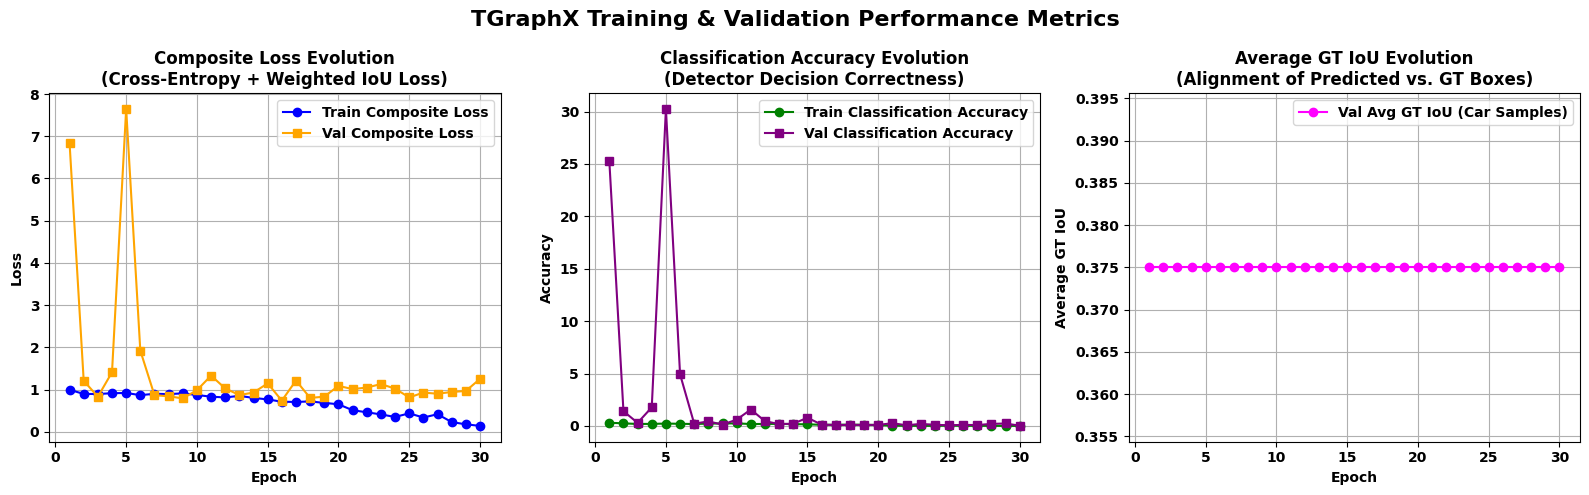

In [11]:
# ==============================================================================
# 7. Plot Training Curves and Metrics (Clear & Detailed)
# ==============================================================================
epochs_list = [ep for (ep, _, _, _, _, _, _, _, _) in train_history]
train_losses = [t_loss for (_, t_loss, _, _, _, _, _, _, _) in train_history]
val_losses = [v_loss for (_, v_loss, _, _, _, _, _, _) in val_history]
train_accs = [t_acc for (_, _, _, t_acc, _, _, _, _, _) in train_history]
val_accs = [v_acc for (_, _, _, v_acc, _, _, _, _) in val_history]
val_gt_ious = [v_gt for (_, _, _, _, _, v_gt, _, _) in val_history]

plt.figure(figsize=(16, 5))
plt.subplot(1, 3, 1)
plt.plot(epochs_list, train_losses, label="Train Composite Loss", marker='o', color="blue")
plt.plot(epochs_list, val_losses, label="Val Composite Loss", marker='s', color="orange")
plt.title("Composite Loss Evolution\n(Cross-Entropy + Weighted IoU Loss)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(epochs_list, train_accs, label="Train Classification Accuracy", marker='o', color="green")
plt.plot(epochs_list, val_accs, label="Val Classification Accuracy", marker='s', color="purple")
plt.title("Classification Accuracy Evolution\n(Detector Decision Correctness)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(epochs_list, val_gt_ious, label="Val Avg GT IoU (Car Samples)", marker='o', color="magenta")
plt.title("Average GT IoU Evolution\n(Alignment of Predicted vs. GT Boxes)")
plt.xlabel("Epoch")
plt.ylabel("Average GT IoU")
plt.legend()
plt.grid(True)

plt.suptitle("TGraphX Training & Validation Performance Metrics", fontsize=16)
plt.tight_layout()
plt.show()

In [12]:
# --- Simple detector label function ---
def get_detector_label(boxes):
    """Assume that if any box is returned, the detector predicts 'car'."""
    return "car" if boxes and len(boxes) > 0 else "not car"

# --- Function to get TGraphX model prediction ---
def get_tgraphx_prediction(crops):
    # Build graph from crops (attach a dummy label; it'll be ignored)
    graph = build_detection_graph(crops, label=0)
    graph.node_features = graph.node_features.to(device)
    if graph.edge_index is not None:
        graph.edge_index = graph.edge_index.to(device)
    # Create a batch vector for the graph (all nodes belong to graph 0)
    graph.batch = torch.zeros(graph.node_features.size(0), dtype=torch.long, device=device)
    model_tgraphx.eval()
    with torch.no_grad():
        # Use our forward helper to get logits and pooled features.
        logits, pooled = forward_with_features(model_tgraphx, graph.node_features, graph.edge_index, graph.batch)
        # Pass the pooled features through the IoU head.
        iou_pred = iou_head(pooled).squeeze(1)
        # Although composite_loss uses both, for prediction you only need the classification logits.
        pred = logits.argmax(dim=1).item()
    return "car" if pred == 1 else "not car"


# --- Demo: iterate over a random subset of images from the VOC dataset ---
demo_indices = random.sample(range(len(dataset)), 500)
mis_detections = []  # will store tuples: (image, gt_label, yolo_label, retina_label, tgraphx_label)

for idx in demo_indices:
    image, target = dataset[idx]  # VOC returns (PIL image, annotation dict)
    image_np = np.array(image)

    # Get ground truth label from annotation (using our modified function)
    gt_label = get_ground_truth_label(target['annotation'])

    # Run YOLO and RetinaNet detectors
    yolo_boxes = run_yolo_inference(model_yolo, image_np)
    retina_boxes = run_retina_inference(model_retina, image_np)
    yolo_label = get_detector_label(yolo_boxes)
    retina_label = get_detector_label(retina_boxes)

    # Build TGraphX prediction only if at least one detector detects a car
    if yolo_boxes and retina_boxes:
        crop_yolo = crop_box(image_np, yolo_boxes[0])
        crop_retina = crop_box(image_np, retina_boxes[0])
        union_box = [
            min(yolo_boxes[0][0], retina_boxes[0][0]),
            min(yolo_boxes[0][1], retina_boxes[0][1]),
            max(yolo_boxes[0][2], retina_boxes[0][2]),
            max(yolo_boxes[0][3], retina_boxes[0][3])
        ]
        crop_union = crop_box(image_np, union_box)
        crops = [crop_yolo, crop_retina, crop_union]
        tgraphx_label = get_tgraphx_prediction(crops)
    else:
        tgraphx_label = "not car"

    # We choose to display images where at least one detector predicted "car" but ground truth is "not car"
    # and TGraphX also agrees with ground truth ("not car").
    if (yolo_label == "car" or retina_label == "car") and (gt_label == "not car") and (tgraphx_label == "not car"):
        mis_detections.append((image_np, gt_label, yolo_label, retina_label, tgraphx_label))

# Plot mis-detected images
if len(mis_detections) == 0:
    print("No mis-detections found in the demo subset.")
else:
    cols = 2
    rows = (len(mis_detections) + 1) // cols
    plt.figure(figsize=(10, 5 * rows))
    for i, (img, gt, yolo_pred, retina_pred, tgraphx_pred) in enumerate(mis_detections):
        plt.subplot(rows, cols, i+1)
        plt.imshow(img)
        plt.title(f"GT: {gt}\nYOLO: {yolo_pred} | Retina: {retina_pred}\nTGraphX: {tgraphx_pred}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()


TypeError: int() argument must be a string, a bytes-like object or a number, not 'list'


# 10. Summary & Conclusion

In this notebook we:
- Loaded a small object detection dataset and prepared the images and annotations.
- Set up and ran two object detection models: YOLOv11 and RetinaNet.
- Evaluated the models using key metrics such as Precision, Recall, IoU, mAP, and inference time.
- Analyzed and visualized the differences in bounding box predictions by generating individual crops.
- Constructed graph representations from the detection crops using TGraphX’s backend.
- Built and trained a CNN‑GNN model on the generated graphs, logging training loss and (dummy) graph accuracy.
- Visualized training progress and provided a framework for further analysis and error case study.

This complete pipeline demonstrates how detection outputs can be integrated into graph-based representations for advanced spatial analysis. Future work could include hyperparameter tuning, improved loss functions (such as GIoU or CIoU), and multi-object graphs.
